In [5]:
# Import some libs
from tree_test0 import numDevTotal,createTree0,createTree1
from numpy import arange
import numpy as np
from math import sqrt,ceil
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
#%% Step 1: Realistic hardware execution data collection
'''
          RPi	JetNano	Ultra96	  NCS GTX1060 FX6300
Cost ($)  40	    99	  250	  75	180	    70


ResNet-50 Latency (s)	FPS					﻿
Time	RaspberryPi	JetsonNano	Ultra96	  NCS	      GTX1060	  FX6300
mean	  0.479 	7.621  	34.50460762	4.587721577	26.03236414	3.733683597
std	      0.013 	0.962 	 1.1926361	0.060705309	3.373674602	0.081496673
min	 0.458068627	5.228348103	34.6740638	4.202316317	16.56973372	3.381337048
max	 0.528353566	10.25819887	34.73669585	4.797428578	37.85584494	3.930539506


Tiny Yolo3	FPS					﻿
Time	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
mean	0.34862538	10.44329942	43.51077173	4.203506884	16.98980166	5.935877522
std	0.008219176	0.837386835	1.848084288	0.051172827	0.592641537	1.27451256
min	0.307452117	5.724688291	37.86157807	4.070666775	12.22449054	2.991530976
max	0.39044198	14.47932353	50.1403931	4.3785521	18.2488412	4.894642813

'''
# time data
# here mu and std for devices are in unit of FPS
# Dev:	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
muRes = [ 0.479,7.621,34.5046,4.587,26.0323,3.733]
stdRes = [0.013,0.962,1.19,0.0607,3.37367,0.081]
muYolo = [0.3486,10.443,43.51,4.2035,16.9898,5.9358]
stdYolo = [0.0082,0.83738,1.848,0.051,0.59264,3.2745]




#power data
'''
ResNet-50 Power (Watts)	Raspberry Pi 3	Jetson Nano	Ultra96	Compute Stick(NCS)	GTX1060 6gb	FX-6300 CPU
Idle	1.8	2.2	6.2	0.4	10	72
Infer	4.8	5.6	7.6	1.9	122	145

Tiny Yolo3 Power (Watts)	Raspberry Pi 3	Jetson Nano	Ultra96	Compute Stick(NCS)	GTX1060 6gb	FX-6300 CPU
Idle	1.8	2.3	7.4	0.4	10	72
Infer	4.8	11.7	9.2	2.1	122	150
'''
idleRes = [1.8,2.2,6.2,0.4,10,72]
workRes = [4.8,5.6,7.6,1.9,122,145]

idleYolo = [1.8,2.3,7.4,0.4,10,72] 
workYolo = [4.8,11.7,9.2,2.1,122,150]

pRes = np.array([11.1756, 1.1192, 0.2618, 0.4349, 6.738, 42.766])
pYolo = np.array([15.1416, 1.4592, 0.2614, 0.5223, 7.99, 83.166])

0.2751380052534453


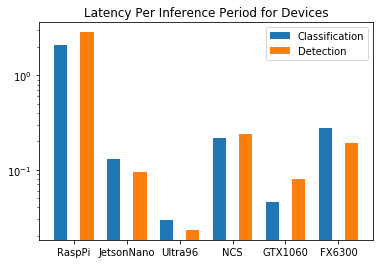

In [7]:
#%% Step 2: Latency estimation for each inference function loop(expectation)
# t_Total = t_inf + t_e2f + t_f2c

# bandwidth assumption using Wifi
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8016573
B_e2f = 135*1024/8  #135Mbps Wifi  IEEE802.11n convert to kb/s
B_f2c = 135*1024/8  #135Mbps Wifi  IEEE802.11n convert to kb/s

# S_c: size of control packet, transfer inference results
# S_dat: size of data needs to be processed,offloading from edge to fog or cloud
S_c = 1  # just assume to be 1kb, could be smaller in reality
#  image file size https://toolstud.io/photo/megapixel.php?width=640&height=480&compare=video&calculate=compressed
S_datYolo = 188    # 1280*720 JPG 100% 24bit/pixel	188 KB
S_datRes = 62.7    # 640*480
def getTimeTotal(muDevFreq,devLevel,S_c,S_dat,B_e2f,B_f2c):
    t_inf = 1/muDevFreq
    
    if devLevel==0: #highest cloud level 
        t_e2f = S_dat/B_e2f
        t_f2c = S_dat/B_f2c
            
    elif devLevel==1:
        t_e2f = S_dat/B_e2f
        t_f2c = S_c/B_f2c

    elif devLevel==2: 
        t_e2f = S_c/B_e2f
        t_f2c = S_c/B_f2c
    t_Total = t_inf + t_e2f + t_f2c
    return t_Total

print( getTimeTotal(muRes[5],0,S_c,S_datRes,B_e2f,B_f2c) )
# Dev:	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
# Level: 0 cloud; 1 fog; 2 edge
tRes_rpi = getTimeTotal(muRes[0],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_jetnano = getTimeTotal(muRes[1],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_u96 = getTimeTotal(muRes[2],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_ncs = getTimeTotal(muRes[3],2,S_c,S_datRes,B_e2f,B_f2c) 
tRes_gtx1060 = getTimeTotal(muRes[4],0,S_c,S_datRes,B_e2f,B_f2c)
tRes_fx6300 = getTimeTotal(muRes[5],0,S_c,S_datRes,B_e2f,B_f2c)   

tYolo_rpi = getTimeTotal(muYolo[0],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_jetnano = getTimeTotal(muYolo[1],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_u96 = getTimeTotal(muYolo[2],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_ncs = getTimeTotal(muYolo[3],2,S_c,S_datYolo,B_e2f,B_f2c) 
tYolo_gtx1060 = getTimeTotal(muYolo[4],0,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_fx6300 = getTimeTotal(muYolo[5],0,S_c,S_datYolo,B_e2f,B_f2c)   

# visualization
import matplotlib.pyplot as plt

res_bars = [tRes_rpi,tRes_jetnano,tRes_u96,tRes_ncs,tRes_gtx1060,tRes_fx6300]
yolo_bars = [tYolo_rpi,tYolo_jetnano,tYolo_u96,tYolo_ncs,tYolo_gtx1060,tYolo_fx6300]

x_pos = np.arange(6)
fig, ax = plt.subplots()
ax.bar(x_pos - 0.25, res_bars, 0.25)
ax.bar(x_pos + 0.25, yolo_bars, 0.25)
ax.set_xticklabels(["RaspPi","JetsonNano","Ultra96","NCS","GTX1060","FX6300"], rotation='horizontal')
ax.set_xticks(x_pos)
plt.legend(["Classification","Detection"])
plt.semilogy()
titlestr = 'Latency Per Inference Period for Devices'
plt.title(titlestr)
plt.savefig(titlestr+'.png', dpi=300)
plt.show()  

In [9]:
#%% Step 3: Cost computation for devices: dev cost + electricity cost
#  Power estimation for 2 years cycle
#  Device cost from commercial price
'''
          RPi	JetNano	Ultra96	  NCS GTX1060 FX6300
Cost ($)  40	    99	  250	  75	180	    70

'''
devCostList = np.array([40,99,250,75,180,70])


# set electricity price as $0.1/kwh
# cycle length unit in months
def getTotalCost(devCost,devNum,pEachInf,muInTotal,lenCycle,pDevIdle):
    elecPrice = 0.1  # $0.1/kwh
    # working phase power
    total = devCost*devNum + pEachInf*muInTotal*24*30*lenCycle/1000*elecPrice
    # idle phase power
    idleRatio = 0.5
    total = total + pDevIdle*24*30*lenCycle/1000*elecPrice*idleRatio
    return total




#%% Batch experiments for different settings 
lenCycle = 24 # 36 months=3 years


# cv: coefficient of variance(std/mu) ==> complexity of input
cvList = [0.1,0.5,1.0,1.5,2.0]
muNum= 100    
muMax = 50 

def evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle):
    conf = 0.99
    
    #muNum= 100    
    #muMax = 5
    muStep = muMax/muNum
    
    cvNum = len(cvList)
    costDat = np.zeros((muNum,cvNum))
    row=0
    col=0
    for muIn in arange(muStep, muMax+muStep, muStep):
        for cV in cvList:                        
            cloud = createTree1(inMu0=muIn,inStd0=muIn*cV)             
            
            devNum = numDevTotal(muDevFreq=muDevFreq,stdDevFreq=stdDevFreq,level=devLevel,tree=cloud,conf0=conf)
            #print('Num of devices:',devNum)
            costDat[row,col] = getTotalCost(devCost,devNum,pEachInf,muIn,lenCycle,pDevIdle)
            #reliaFog(N_fog,N_cam,muIn,cV,muRun,stdRun)
            col=col+1
        row=row+1
        col=0
    return costDat

costRes = np.zeros((6,muNum,5))
costYolo = np.zeros((6,muNum,5))
for i in range(6):
    devCost = devCostList[i]
    #   [RPi,JetNano,Ultra96,NCS,GTX1060,FX6300]
    if i in [0,1,2,3]:
        devLevel = 2
    else:
        devLevel = 0
    
        
    muDevFreq = muRes[i]
    stdDevFreq = stdRes[i]
    pEachInf = pRes[i]
    pDevIdle = idleRes[i]       
    costRes[i]=evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle)
    
    muDevFreq = muYolo[i]
    stdDevFreq = stdYolo[i]
    pEachInf = pYolo[i]
    pDevIdle = idleYolo[i]       
    costYolo[i]=evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle)    




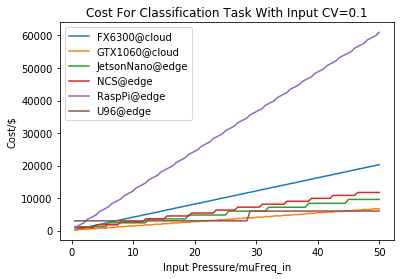

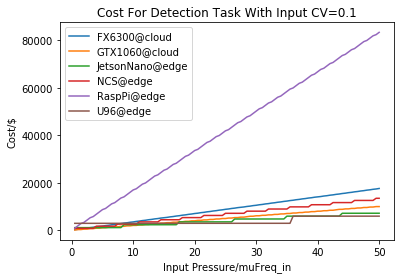

In [10]:
# set design application input complexity 
# cvList = [0.1,0.5,1.0,1.5,2.0]
# very low input uncertainty
cvGoal = 0.1
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()

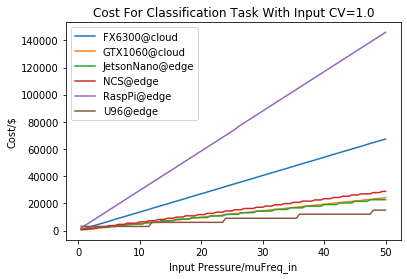

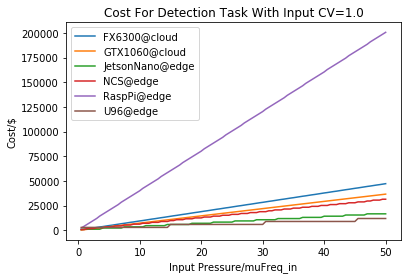

In [11]:
# set design application input complexity
# cvList = [0.1,0.5,1.0,1.5,2.0]
# medium level input uncertainty
cvGoal = 1.0
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()

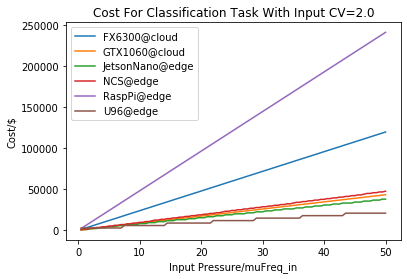

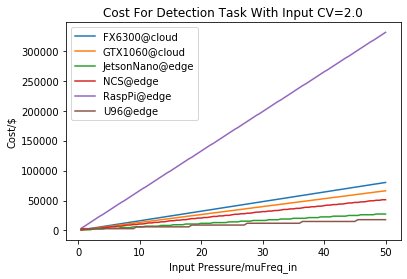

In [12]:
# set design application input complexity
# cvList = [0.1,0.5,1.0,1.5,2.0]
# relative high input uncertainty
cvGoal = 2.0
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
#titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()